# Normalized Baseline: Reduce Tonal Noise Model 3

After testing, the most ideal normalization was "normalize_wav" which normalizes the waveform to have a mean of zero (mean=0) and a standard deviation of unity (std=1) before computing the spectrogram. After several testing runs with different spectrogram generation parameters, the most ideal were determined to be: 


  "spectrogram": {
    "rate": 3000,
    "window": 0.032,
    "step": 0.001,
    "freq_min": 100,
    "freq_max": 1200,
    "transforms": [
      {
        "name": "normalize",
        "mean": 0,
        "std": 1.0
      }
    ],
    "window_func": "hamming",
    "type": "MagSpectrogram",
    "duration": 1.0
  }
}

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Functions

In [8]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [9]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

In [7]:
main_folder = r'E:\baseline-with-normalization-reduce-tonal'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'
recipe_file = main_folder + '\\' + 'resnet_recipe-1.json'
pos_folder = main_folder + '\\' + r'annots\pos'
neg_folder = main_folder + '\\' + r'annots\neg'
file_durations_file = main_folder + '\\' + 'all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'final-baseline-db-normalized-rtn.h5'
temp_folder = main_folder + '\\' + 'rs-temp'

data_folder = r'D:\ringed-seal-data'

In [8]:
model_names = [main_folder + '\\' + 'rs-model-3.kt']

temp_folders = [main_folder + '\\' + 'rs-temp-3']

## Test

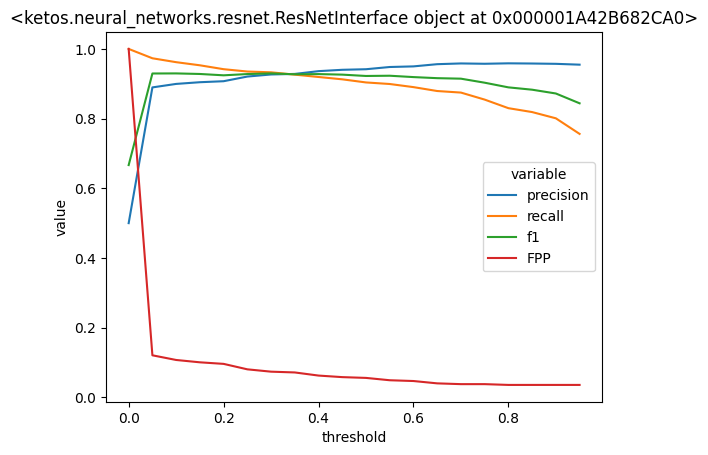

In [12]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics-3'
temp_folder = main_folder + '\\' + 'temp-3'

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/test')
    
    classification_csv = "classifications-3.csv"
    metric_csv = "metrics-3.csv"
    stats_csv = "stats-3.csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

Confusion Matrix


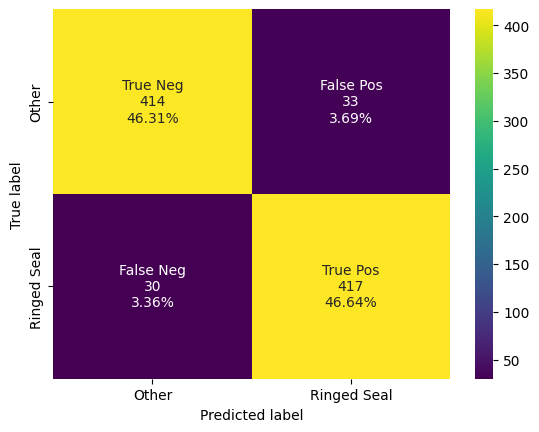

In [13]:
threshold = 0.3

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\metrics-3\classifications-3.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## Apply to Pearce Point Data

In [10]:
# Create a database
neg_folder = r'E:\baseline-with-normalization-reduce-tonal\annots\neg'
pos_folder = r'E:\baseline-with-normalization-reduce-tonal\annots\pos'
db_name = r'E:\baseline-with-normalization-reduce-tonal\pp\pp-all.h5'
data_folder = r'D:\ringed-seal-data'

## Create Database ##
# negatives tables and standarize for ketos
pp_neg = pd.read_excel(neg_folder + '\\' + 'PP-negs-joined.xlsx')
pp_neg = pp_neg.ffill()

pp_neg_sl = sl.standardize(table=pp_neg)

pp_pos = pd.read_csv(pos_folder + '\\' + 'PP_all_formatted_1sec.csv')
pp_pos = pp_pos.ffill()

pp_pos_sl = sl.standardize(table=pp_pos, start_labels_at_1=True)

pp_all = pd.concat([pp_pos_sl, pp_neg_sl])

In [19]:
pp_all.to_excel(r'E:\baseline-with-normalization-reduce-tonal\pp\all_pp_annots.xlsx')

In [11]:
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'all', selections=pp_all, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:15<00:00, 10.71it/s]

168 items saved to E:\baseline-with-normalization-reduce-tonal\pp\pp-all.h5


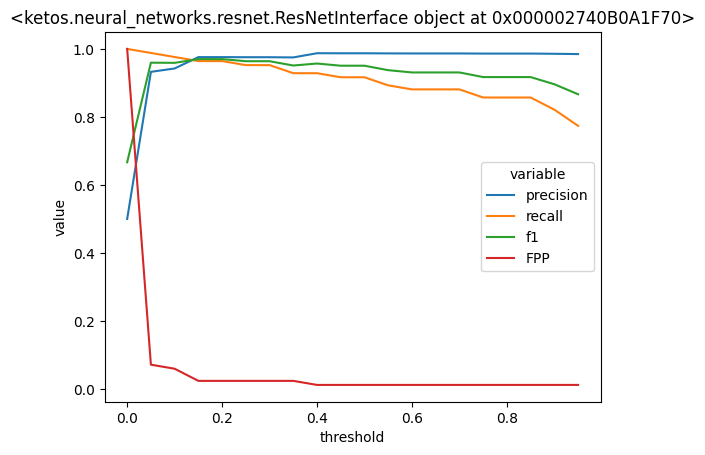

In [14]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\pp\metrics'
temp_folder = r'E:\baseline-with-normalization-reduce-tonal\pp\temp'
db_name = r'E:\baseline-with-normalization-reduce-tonal\pp\pp-all.h5'

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/all')
    
    classification_csv = "classifications-pp.csv"
    metric_csv = "metrics-pp.csv"
    stats_csv = "stats-pp.csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

Confusion Matrix


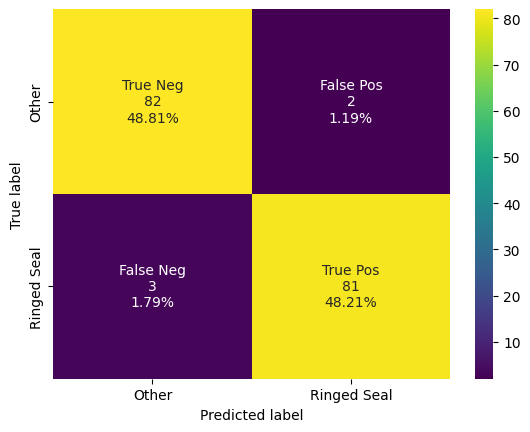

In [17]:
threshold = 0.15

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\pp\metrics\classifications-pp.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## Apply to Pearce Point Audio

In [27]:
#annots = pd.read_excel(r'E:\final-baseline-detector\pearce-point-test\all_pp_annots.xlsx')
annots = pd.read_excel(r'E:\baseline-with-normalization-reduce-tonal\pp\all_pp_annots.xlsx')

annotsf = annots.ffill()

audio_folder = r'E:\baseline-with-normalization-reduce-tonal\pp\audio'

for idex, row in annotsf.iterrows():
    shutil.copyfile(annotsf.loc[idex]['filename'], audio_folder + '\\' + annotsf.loc[idex]['filename'].split('\\')[-1])

print('done')

done


In [31]:
detections_csv = r'E:\baseline-with-normalization-reduce-tonal\pp\detections.csv'
audio_folder = r'E:\baseline-with-normalization-reduce-tonal\pp\audio'
temp_folder_pp = r'E:\baseline-with-normalization-reduce-tonal\pp\temp-audio'
model_name = r'E:\baseline-with-normalization-reduce-tonal\rs-model-3.kt'

# Look at detections above this threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

model = ResNetInterface.load(model_file=model_name, new_model_folder=temp_folder_pp)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 636/636 [01:45<00:00,  6.03it/s]


In [32]:
grouped_detections_csv = r'E:\baseline-with-normalization-reduce-tonal\pp\pos_detections_pearce_point_audio-thresh05.csv'
audio_folder = r'E:\baseline-with-normalization-reduce-tonal\pp\audio'
raven_txt_name = r'E:\baseline-with-normalization-reduce-tonal\pp\raven-formatted-detections-pearce-point-thresh05.txt'

In [33]:
# Filter the detections for only the positive results 
detections_filtered = filter_by_label(detections, labels=1).reset_index(drop=True)
print(detections_filtered)
detections_grp = merge_overlapping_detections(detections_filtered)
print(detections_grp)
detections_grp.to_csv(grouped_detections_csv, index=False)

results_table = pd.read_csv(grouped_detections_csv)

cols = ['filename']
results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
results_table['Selection'] = results_table.index +1
results_table['View'] = 'Spectrogram 1'
results_table['Channel'] = 1
results_table['Begin Path'] = audio_folder + '\\' + results_table.filename
results_table['File Offset (s)'] = results_table.start
results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
results_table['Begin File'] = results_table['Begin File']
results_table['Low Freq (Hz)'] = 100
results_table['High Freq (Hz)'] = 1200

results_table.to_csv(raven_txt_name, index=False, sep='\t')

                        filename  start    end  label     score
0    1208234033.020419202219.wav   43.5   44.5      1  0.996938
1    1208234033.020419202219.wav   57.5   58.5      1  0.723453
2    1208234033.020419202219.wav   58.0   59.0      1  0.991385
3    1208234033.020419202219.wav   63.5   64.5      1  0.980828
4    1208234033.020419202219.wav   64.0   65.0      1  0.980061
..                           ...    ...    ...    ...       ...
551  1208234033.021207082219.wav  245.0  246.0      1  0.776835
552  1208234033.021207082219.wav  259.5  260.5      1  0.592200
553  1208234033.021207082219.wav  276.0  277.0      1  0.990770
554  1208234033.021207082219.wav  291.5  292.5      1  0.863219
555  1208234033.021207082219.wav  292.0  293.0      1  0.866238

[556 rows x 5 columns]
                        filename  start    end  label     score
0    1208234033.020419202219.wav   43.5   44.5      1  0.996938
1    1208234033.020419202219.wav   57.5   59.0      1  0.857419
2    1208234033.

## Apply to Ulu 2023 Data

In [44]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [46]:
ulu_neg_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\negatives-manual.xlsx')
ulu_neg_2023 = ulu_neg_2023.ffill()
ulu_neg_2023 = sl.standardize(table=ulu_neg_2023)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg_2023)))

Negatives standardized? True


In [47]:
ulu_pos_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx')
ulu_pos_2023 = ulu_pos_2023.ffill()
ulu_pos_2023 = sl.standardize(table=ulu_pos_2023, start_labels_at_1=True)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_pos_2023)))

Negatives standardized? True


In [48]:
ulu_2023_all = pd.concat([ulu_pos_2023, ulu_neg_2023], sort=False)

In [55]:
file_durations = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\file_durations_ulu2023.xlsx')
drop_rows_all = drop_rows(file_durations, ulu_2023_all)
ulu_2023_all = ulu_2023_all.drop(drop_rows_all)


cleaning training table of original length 1022
Number of rows to drop (note, one entry may be in list twice): 1


In [61]:
spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5'
data_folder = r'D:\ringed-seal-data'

In [62]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'all', selections=ulu_2023_all, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:30<00:00, 33.23it/s]

1020 items saved to E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5


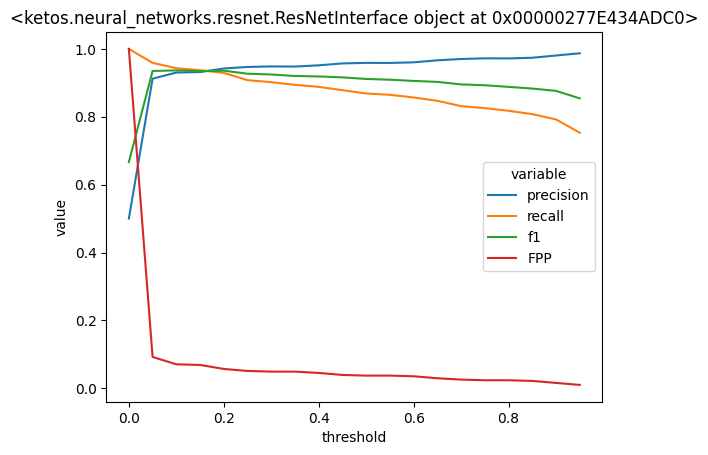

In [64]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics'
temp_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\temp'
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5'
model_names = [r'E:\baseline-with-normalization-reduce-tonal\rs-model-3.kt']

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/all')
    
    classification_csv = "classifications-ulu2023.csv"
    metric_csv = "metrics-ulu2023.csv"
    stats_csv = "stats-ulu2023.csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

Confusion Matrix


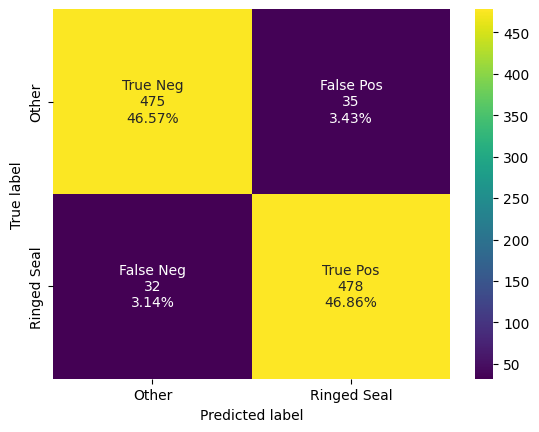

In [65]:
threshold = 0.15

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\classifications-ulu2023.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## Apply to Ulu 2023 Audio Test Subset

In [17]:
detections_csv = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\detections-thresh05.csv'
audio_folder = r'D:\ringed-seal-data\Ulu_2023_St5_Site65\test-subset'
temp_folder_pp = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\temp-audio'
model_name = r'E:\baseline-with-normalization-reduce-tonal\rs-model-3.kt'

# Look at detections above this threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

model = ResNetInterface.load(model_file=model_name, new_model_folder=temp_folder_pp)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1498/1498 [03:14<00:00,  7.72it/s]


In [18]:
grouped_detections_csv = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\pos_detections_ulu2023_audio-thresh05.csv'
audio_folder = r'D:\ringed-seal-data\Ulu_2023_St5_Site65\test-subset'
raven_txt_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\raven-formatted-detections-ulu2023-thresh05.txt'

In [19]:
# Filter the detections for only the positive results 
detections_filtered = filter_by_label(detections, labels=1).reset_index(drop=True)
print(detections_filtered)
detections_grp = merge_overlapping_detections(detections_filtered)
print(detections_grp)
detections_grp.to_csv(grouped_detections_csv, index=False)

results_table = pd.read_csv(grouped_detections_csv)

cols = ['filename']
results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
results_table['Selection'] = results_table.index +1
results_table['View'] = 'Spectrogram 1'
results_table['Channel'] = 1
results_table['Begin Path'] = audio_folder + '\\' + results_table.filename
results_table['File Offset (s)'] = results_table.start
results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
results_table['Begin File'] = results_table['Begin File']
results_table['Low Freq (Hz)'] = 100
results_table['High Freq (Hz)'] = 1200

results_table.to_csv(raven_txt_name, index=False, sep='\t')

                   filename  start    end  label     score
0     7266.230520000010.wav   70.5   71.5      1  0.575405
1     7266.230520000010.wav  147.0  148.0      1  0.998066
2     7266.230520000010.wav  147.5  148.5      1  0.964786
3     7266.230520000010.wav  185.5  186.5      1  0.838717
4     7266.230520000010.wav  186.0  187.0      1  0.968911
...                     ...    ...    ...    ...       ...
1341  7266.230520031510.wav  140.5  141.5      1  0.927529
1342  7266.230520031510.wav  141.0  142.0      1  0.999995
1343  7266.230520031510.wav  142.5  143.5      1  0.999846
1344  7266.230520031510.wav  288.0  289.0      1  1.000000
1345  7266.230520031510.wav  288.5  289.5      1  1.000000

[1346 rows x 5 columns]
                  filename  start    end  label     score
0    7266.230520000010.wav   70.5   71.5      1  0.575405
1    7266.230520000010.wav  147.0  148.5      1  0.981426
2    7266.230520000010.wav  185.5  187.0      1  0.903814
3    7266.230520000010.wav  205.5  

## Fine Tuning Ulu2023

In [69]:
ulu_neg_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\negatives-manual.xlsx')
ulu_neg_2023 = ulu_neg_2023.ffill()

num_tr = int(len(ulu_neg_2023)*0.70)
num_val = int(len(ulu_neg_2023)*0.20)
num_te = len(ulu_neg_2023) - num_tr - num_val

ulu_neg_tr = ulu_neg_2023[0:num_tr]
ulu_neg_val = ulu_neg_2023[num_tr:num_tr+num_val]
ulu_neg_te = ulu_neg_2023[num_tr+num_val:len(ulu_neg_2023)]

ulu_neg_tr = sl.standardize(table=ulu_neg_tr)
ulu_neg_val = sl.standardize(table=ulu_neg_val)
ulu_neg_te = sl.standardize(table=ulu_neg_te)

ulu_pos_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx')
ulu_pos_2023 = ulu_pos_2023.ffill()

num_tr = int(len(ulu_pos_2023)*0.70)
num_val = int(len(ulu_pos_2023)*0.20)
num_te = len(ulu_pos_2023) - num_tr - num_val

ulu_pos_tr = ulu_pos_2023[0:num_tr]
ulu_pos_val = ulu_pos_2023[num_tr:num_tr+num_val]
ulu_pos_te = ulu_pos_2023[num_tr+num_val:len(ulu_pos_2023)]

ulu_pos_tr = sl.standardize(table=ulu_pos_tr, start_labels_at_1=True)
ulu_pos_val = sl.standardize(table=ulu_pos_val, start_labels_at_1=True)
ulu_pos_te = sl.standardize(table=ulu_pos_te, start_labels_at_1=True)

train = pd.concat([ulu_pos_tr, ulu_neg_tr])
test = pd.concat([ulu_pos_te, ulu_neg_te])
val = pd.concat([ulu_pos_val, ulu_neg_val])

In [70]:
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5'
data_folder = r'D:\ringed-seal-data'
spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

In [71]:
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [00:23<00:00, 30.11it/s]


714 items saved to E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:07<00:00, 28.73it/s]


204 items saved to E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:03<00:00, 29.98it/s]

104 items saved to E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5


In [23]:
ft_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune'
model_folder = r'E:\baseline-with-normalization-reduce-tonal'
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5'

pretrained_model = [model_folder + "\\" + "rs-model-3.kt"]

new_model = [ft_folder + "\\" + "rs-model-3-ft.kt"]

spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

np_seeds = [1736]
tf_seeds = [1660]

In [24]:
for idx, model in enumerate(pretrained_model):

    # Set the random seed for numpy and tensorflow
    np.random.seed(np_seeds[idx])
    tf.random.set_seed(tf_seeds[idx])
    
    # Set the batch size and number of epochs for training
    batch_size = 16
    n_epochs = 80
    
    # Set the log folder and checkpoint folder
    log_folder = ft_folder + '\\' + 'logs'
    checkpoint_folder = ft_folder + '\\' + 'checkpoints'
    
    # Open the database file in read mode
    db = dbi.open_file(db_name, 'r')
    
    # Open the training and validation tables respectively
    train_data = dbi.open_table(db, "/train/data")
    val_data = dbi.open_table(db, "/val/data")
    
    # Create batches of training data of size batch size, using the specified data table
    # This returns indices of the data in each batch along with their labels
    train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                        output_transform_func=ResNetInterface.transform_batch,
                                        shuffle=True, refresh_on_epoch_end=True)
    
    # Create batches of validation data of size batch size, using the specified data table 
    # This returns indices of the data in each batch along with their labels 
    val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                       output_transform_func=ResNetInterface.transform_batch,
                                       shuffle=False, refresh_on_epoch_end=False)
    
    # Load the pretrained model, replacing the top (aka. classification layers). This method inherently freezes the base.
    resnet = ResNetInterface.load(model, replace_top=True)
    
    # Set the training and validation generators to the batch generators created above
    resnet.train_generator = train_generator
    resnet.val_generator = val_generator
    
    # Set the model log and checkpoint directory
    resnet.log_dir = log_folder
    resnet.checkpoint_dir = checkpoint_folder
    
    # digging into their scripts for fine tuning
    # resnet.py, "clone with new top"
    
    # Train the model, looping through all of the training and validation data
    # See code map for more information
    resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=True)
    
    # Close the database
    db.close()
    
    # Save the model file, and keep track of the spectrogram parameters used to generate that model
    resnet.save(new_model[idx], audio_repr_file=spectro_file)
    
    print('Done')

Done


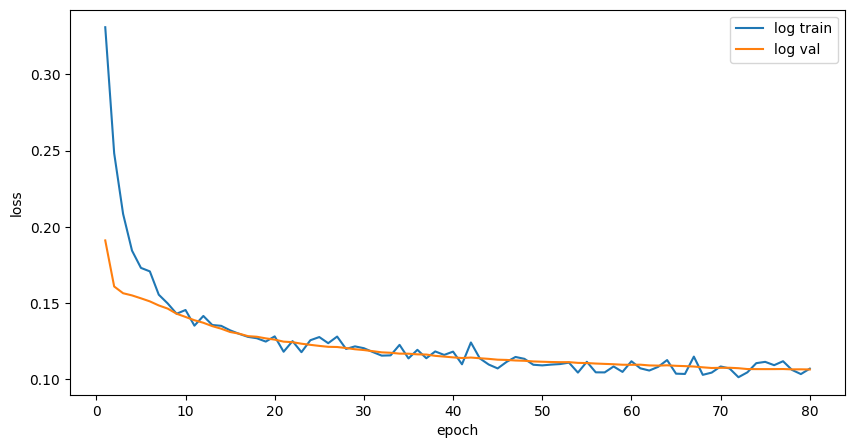

In [25]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

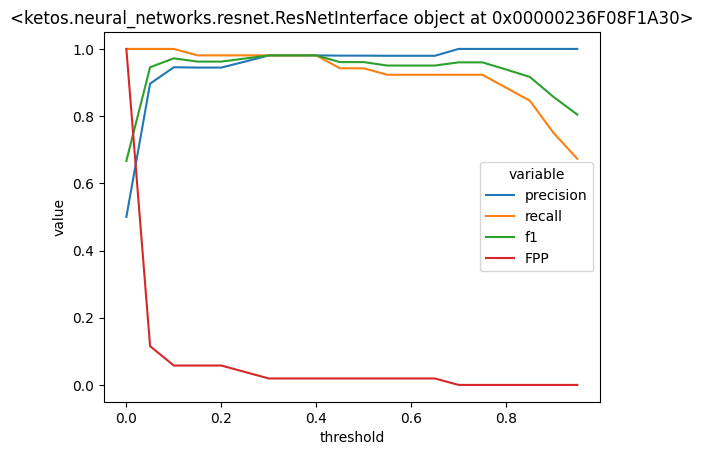

In [26]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\metrics'
temp_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\temp'
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\ulu_2023_split-db.h5'
model_names = [r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\rs-model-3-ft.kt']

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/test')
    
    classification_csv = "classifications-ulu2023-ft.csv"
    metric_csv = "metrics-ulu2023-ft.csv"
    stats_csv = "stats-ulu2023-ft.csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

Confusion Matrix


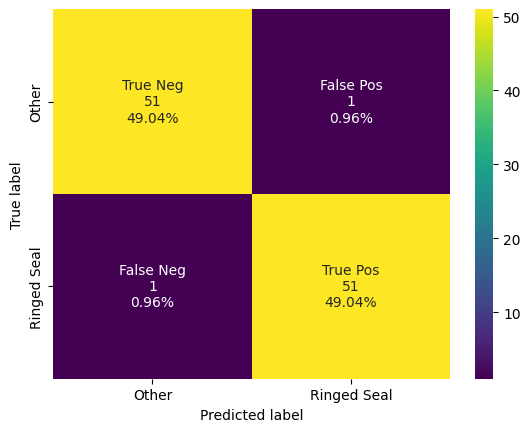

In [27]:
threshold = 0.4

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\metrics\classifications-ulu2023-ft.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

In [28]:
detections_csv = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\detections.csv'
audio_folder = r'D:\ringed-seal-data\Ulu_2023_St5_Site65\test-subset'
temp_folder_pp = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\temp-audio'
model_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\rs-model-3-ft.kt'

# Look at detections above this threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

model = ResNetInterface.load(model_file=model_name, new_model_folder=temp_folder_pp)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

  0%|                                                                                         | 0/1498 [00:00<?, ?it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 46 samples were padded on the left and 0 samples were padded on the right


100%|██████████████████████████████████████████████████████████████████████████████| 1498/1498 [03:25<00:00,  7.31it/s]


In [29]:
grouped_detections_csv = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\pos_detections_ulu2023_audio-thresh05-ft.csv'
audio_folder = r'D:\ringed-seal-data\Ulu_2023_St5_Site65\test-subset'
raven_txt_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\fine-tune\raven-formatted-detections-ulu2023-thresh05-ft.txt'

In [30]:
# Filter the detections for only the positive results 
detections_filtered = filter_by_label(detections, labels=1).reset_index(drop=True)
print(detections_filtered)
detections_grp = merge_overlapping_detections(detections_filtered)
print(detections_grp)
detections_grp.to_csv(grouped_detections_csv, index=False)

results_table = pd.read_csv(grouped_detections_csv)

cols = ['filename']
results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
results_table['Selection'] = results_table.index +1
results_table['View'] = 'Spectrogram 1'
results_table['Channel'] = 1
results_table['Begin Path'] = audio_folder + '\\' + results_table.filename
results_table['File Offset (s)'] = results_table.start
results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
results_table['Begin File'] = results_table['Begin File']
results_table['Low Freq (Hz)'] = 100
results_table['High Freq (Hz)'] = 1200

results_table.to_csv(raven_txt_name, index=False, sep='\t')

                   filename  start    end  label     score
0     7266.230520000010.wav   70.5   71.5      1  0.644534
1     7266.230520000010.wav  147.0  148.0      1  0.992497
2     7266.230520000010.wav  147.5  148.5      1  0.948699
3     7266.230520000010.wav  185.5  186.5      1  0.820296
4     7266.230520000010.wav  186.0  187.0      1  0.939343
...                     ...    ...    ...    ...       ...
1577  7266.230520031510.wav  140.5  141.5      1  0.899038
1578  7266.230520031510.wav  141.0  142.0      1  0.999848
1579  7266.230520031510.wav  142.5  143.5      1  0.998445
1580  7266.230520031510.wav  288.0  289.0      1  0.999990
1581  7266.230520031510.wav  288.5  289.5      1  0.999994

[1582 rows x 5 columns]
                  filename  start    end  label     score
0    7266.230520000010.wav   70.5   71.5      1  0.644534
1    7266.230520000010.wav  147.0  148.5      1  0.970598
2    7266.230520000010.wav  185.5  187.0      1  0.879819
3    7266.230520000010.wav  205.5  